In [3]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import nltk

In [4]:
german_stop_words = stopwords.words('german')
german_stop_words.append("fur")

In [5]:
# CONSTANTS
DATA_PATH = "D:/10kgerdataset/"
TRAIN_CSV = "train.csv"
TEST_CSV = "test.csv"

In [6]:
try:
    df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV))
    df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_CSV))
except FileNotFoundError:
    print("File was not found at specific location.")
    raise

In [7]:
def remove_punctuation(document: str) -> str:
    return re.sub(r'[^\w\s]', '', document)

def remove_numbers(document: str) -> str:
    return re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$', '', document)

def map_umlaut(document: str) -> str:
    umlaut_mapping = {
        "ß": "b",
        "ü": "u",
        "ä": "a",
        "ö": "o",
        "ë": "e",
    }
    for k, v in umlaut_mapping.items():
        document = document.replace(k, v)
    return document

def stop_word_removal(document: str) -> str:
    return " ".join(w for w in document.split() if w not in german_stop_words)

In [8]:
def run_pre_processing_pipeline(df):
    new_df = df.copy(deep=False)
    
    new_df["text"] = new_df["text"].str.lower()
    new_df["label"] = new_df["label"].str.lower()
    
    new_df = new_df.dropna()
    
    new_df["text"] = new_df["text"].apply(remove_punctuation)
    new_df["text"] = new_df["text"].apply(remove_numbers)
    new_df["text"] = new_df["text"].apply(map_umlaut)
    new_df["text"] = new_df["text"].apply(stop_word_removal)
    return new_df

In [9]:
df_train = run_pre_processing_pipeline(df_train)
df_test = run_pre_processing_pipeline(df_test)

In [10]:
text_features = ["text"]

In [11]:
x_train = np.array(df_train["text"])
y_train = np.array(df_train["label"])
x_test = np.array(df_test["text"])
y_test = np.array(df_test["label"])

In [18]:
from catboost import Pool, CatBoostClassifier

In [20]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

In [131]:
train_pool = Pool(
    x_train, 
    y_train, 
    text_features=[0]
)
valid_pool = Pool(
    x_test, 
    y_test,
    text_features=[0]

)

catboost_params = {
    'iterations': 500,
    'learning_rate': 0.2,
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'early_stopping_rounds': 300,
    'use_best_model': True,
    'verbose': 500,
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6882832	total: 38.7ms	remaining: 19.3s
499:	learn: 0.9092347	total: 17.5s	remaining: 0us


In [98]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix    

In [132]:
y_pred = model.predict(valid_pool)
y_pred = y_pred.reshape(y_pred.shape[0])
y_true = y_test
labels = np.unique(y_true)

In [133]:
y_true.shape, y_pred.shape, labels.shape

((2054,), (2054,), (9,))

In [134]:
print(classification_report(y_true, y_pred, target_names=labels))

               precision    recall  f1-score   support

         etat       0.83      0.74      0.78       141
       inland       0.79      0.80      0.79       213
international       0.84      0.86      0.85       280
       kultur       0.73      0.87      0.79        98
     panorama       0.81      0.77      0.79       337
        sport       1.00      0.97      0.98       235
          web       0.93      0.87      0.90       326
   wirtschaft       0.80      0.84      0.82       298
 wissenschaft       0.83      0.94      0.88       126

     accuracy                           0.85      2054
    macro avg       0.84      0.85      0.84      2054
 weighted avg       0.85      0.85      0.85      2054



In [102]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[103,   1,  10,   7,   2,   2,   7,   0,   0],
       [  4, 170,   0,   2,  16,   0,   1,   8,   2],
       [  3,   4, 279,   0,  11,   0,   1,   7,   0],
       [  9,   4,   1,  99,   4,   0,   3,   5,   0],
       [  2,  16,  20,   5, 272,   0,   4,   6,   7],
       [  3,   0,   1,   0,   3, 240,   0,   1,   0],
       [  2,   7,   8,   1,   2,   0, 283,  12,   2],
       [  3,   4,   5,   0,   9,   2,  14, 232,   4],
       [  1,   4,   2,   4,   4,   0,   3,   7,  96]], dtype=int64)

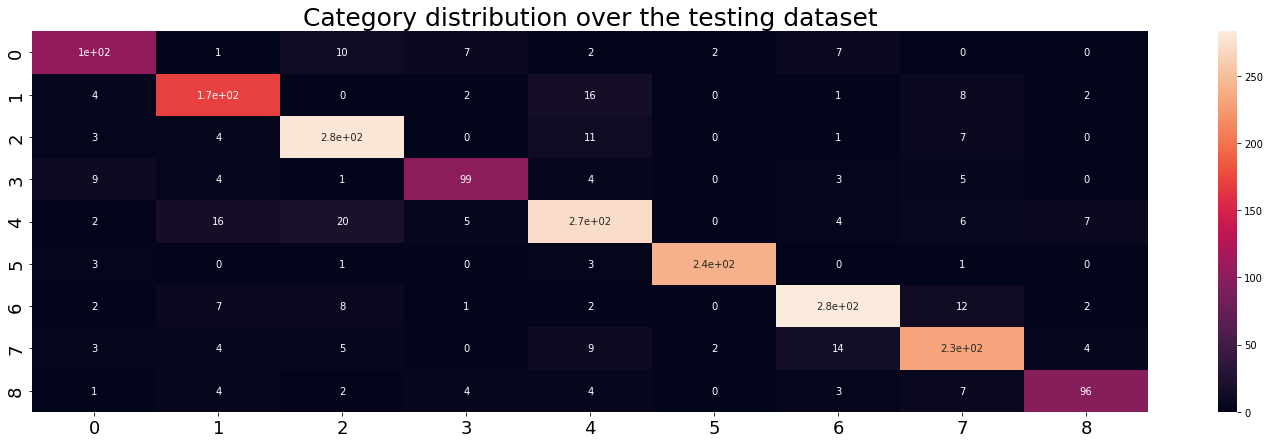

In [135]:
fig_dims = (25, 7)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('Category distribution over the testing dataset', fontsize=25)
plt.xlabel('label', fontsize=24)
plt.ylabel('count', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 
ax = sns.heatmap(cf_matrix, annot=True)

# kfold training

In [117]:
from sklearn.model_selection import KFold

In [118]:
df = pd.read_csv(os.path.join(DATA_PATH, "articles.csv"))

In [119]:
df = run_pre_processing_pipeline(df)

In [125]:
x = np.array(df["text"])
y = np.array(df["label"])

In [122]:
kf = KFold(n_splits=5, shuffle=True)
models = []

In [129]:
for i, (train_index, valid_index) in enumerate(kf.split(x)):
    x_train, y_train = x[train_index], y[train_index]
    x_test, y_test = x[valid_index], y[valid_index]
    
    train_pool = Pool(
        x_train, 
        y_train, 
        text_features=[0]
    )
    valid_pool = Pool(
        x_test, 
        y_test,
        text_features=[0]
    )
    
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=valid_pool)
    models.append(model)

0:	learn: 0.6803358	test: 0.7333333	best: 0.7333333 (0)	total: 52.9ms	remaining: 1m 19s
500:	learn: 0.9072767	test: 0.8506083	best: 0.8540146 (156)	total: 18.2s	remaining: 36.3s
bestTest = 0.8540145985
bestIteration = 156
Shrink model to first 157 iterations.
0:	learn: 0.6837430	test: 0.7128954	best: 0.7128954 (0)	total: 41.1ms	remaining: 1m 1s
500:	learn: 0.9125091	test: 0.8540146	best: 0.8583942 (406)	total: 14s	remaining: 27.9s
1000:	learn: 0.9603310	test: 0.8574209	best: 0.8588808 (852)	total: 27.5s	remaining: 13.7s
1499:	learn: 0.9824775	test: 0.8583942	best: 0.8593674 (1025)	total: 40.9s	remaining: 0us
bestTest = 0.8593673966
bestIteration = 1025
Shrink model to first 1026 iterations.
0:	learn: 0.7023607	test: 0.7065693	best: 0.7065693 (0)	total: 40.1ms	remaining: 1m
500:	learn: 0.9137260	test: 0.8447689	best: 0.8481752 (400)	total: 13.7s	remaining: 27.4s
1000:	learn: 0.9574106	test: 0.8486618	best: 0.8510949 (783)	total: 27.1s	remaining: 13.5s
1499:	learn: 0.9812606	test: 0.8510